# Simulating patterned vegetation

Using the model described in the paper by Konings *et al.* (doi :10.1029/
2011JG001748), we can define a 50x50 grid, in which each square contains values for surface water, soil water, and plant biomass, and see how the plant biomass patterns evolve as we progress the simulation, given different values of daily rainfall.

We can then use the subgraph centrality method described in Mander *et al.* (https://doi.org/10.1098/rsos.160443) to quantify the *connectedness* of the vegetation patterns.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In the pyveg package we have a class called PatternGenerator that implements the model:

In [2]:
from pyveg.src.pattern_generation import PatternGenerator

In [3]:
pg = PatternGenerator()

Once we have an instance of PatternGenerator, we can print its configuration:

In [4]:
pg.print_config()



Current configuration:

m: 50
delta_x: 21
delta_y: 21
diffusion_plant: 0.1
diffusion_soil: 0.1
diffusion_surface: 100
surface_water_frac: 0.1
bare_soil_infiltration: 0.15
grazing_loss: 0.3
soil_water_loss: 0.1
plant_uptake: 10
plant_growth: 0.05
plant_senescence: 0.1
plant_uptake_saturation: 3
water_infilt_saturation: 5
veg_mass_per_cell: 90
fraction_plant_cells: 0.9


## Setting the initial conditions

For the starting pattern of vegetation, we can either use a pre-defined pattern (e.g. taken from a satellite image), or define a random pattern, where the fraction of grid cells with non-zero plant biomass is defined in the configuration file (default is 10%).
If we use a random pattern though, we first need to set the daily rainfall, in order to get values for the equilibrium quantity of soil water in the bare-soil cells.

In [5]:
pg.set_rainfall(1.4)

In [6]:
pg.set_random_starting_pattern()

Now we use this pattern to set the initial values for soil and surface water, and plant biomass for all cells:

In [7]:
pg.initial_conditions()

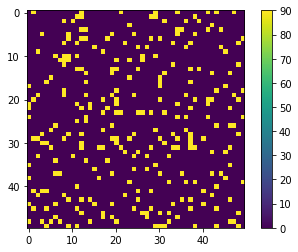

In [8]:
pg.plot_image()

## Running the simulation

Now we can evolve the simulation by 1000 steps.  In each step, some quantity of surface water will enter the soil, some quantity of soil water will be uptaken by the plants, there will be some diffusion from cell-to-cell, and the plants will gain or lose biomass according to the these values and the parameters in the configuration.

In [9]:
pg.evolve_pattern(1000)

Doing 1000 steps with rainfall 1.4mm


Let's see what the plant biomass looks like now: 

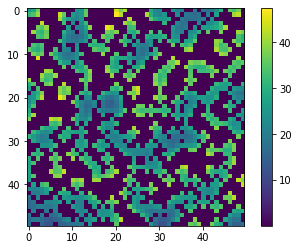

In [10]:
pg.plot_image()

## Quantifying the connectedness of the patterned vegetation

In order to use the subgraph centrality method, we need to convert this into a binary array.  To do this, we define a threshold of (max_val + min_val)/2 and set everything above this to be 0 (i.e. a black pixel, which we define as vegetation), and everything below it as 255 (i.e. a white pixel, in 8-bit color).

In [11]:
binary_array = pg.make_binary()
binary_array

array([[  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ...,   0,   0, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0, 255, 255, ...,   0,   0, 255],
       [255,   0,   0, ..., 255,   0, 255],
       [255, 255, 255, ..., 255, 255, 255]])

The network centrality code is implemented in the "subgraph_centrality.py" module in pyveg.

In [12]:
from pyveg.src.subgraph_centrality import *

In [13]:
feature_vec, _ = subgraph_centrality(binary_array)

The "feature_vector" is the Euler Characteristic values for the different quantiles of vegetation-covered pixels, ordered by subgraph centrality.

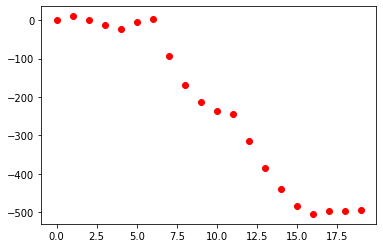

In [14]:
plt.plot(feature_vec, "ro")

The single number that we are using to quantify the connectedness is "offset50", which is essentially the slope of the second half of this feature vector.

In [15]:
offset50 = feature_vector_metrics(feature_vec)["offset50"]
print(offset50)

-257.0


## Generate a precipitation time-series

Let's assume we're in a semi-arid landscape, where we get very little rainfall for most months, then between 1 and 2mm per day in June, July, August


In [16]:
n_months = 36
months = np.array(list(range(n_months)))
daily_rainfall = np.zeros(n_months)
for i in range(len(daily_rainfall)):
    if i%12 == 5: # May
        daily_rainfall[i] = 1.0
    elif i%12 == 6: # June
        daily_rainfall[i] = 1.3
    elif i%12 == 7: # July
        daily_rainfall[i] = 1.7
    elif i%12 == 8: # August
        daily_rainfall[i] = 1.4
    else:
        daily_rainfall[i] = 0.8

    

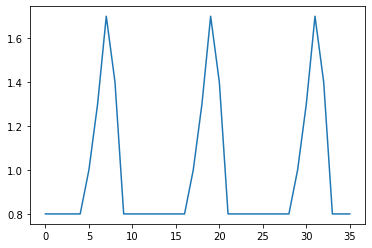

In [17]:
plt.plot(months,daily_rainfall)

## Set a starting vegetation pattern

This time let's load a starting pattern from a csv file - this is one of the "standard" labyrinth patterns we've been using in testing: 

/Users/nbarlow/anaconda3/envs/ds4sdenv/lib/python3.7/site-packages/pyveg/src/pattern_generation.py:462: UserWarning: Matplotlib is currently using ps, which is a non-GUI backend, so cannot show the figure.
  plt.show()


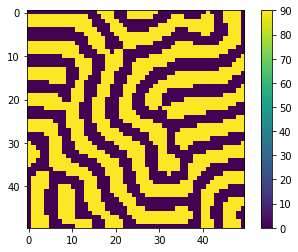

In [18]:
pg.set_starting_pattern_from_file(os.path.join("..","..","pyveg"
                                               ,"testdata",
                                               "binary_labyrinths_50.csv"))
pg.plot_image()

## Run the simulation

Now we can step through this 3-year period, setting the rainfall according to the time series we generated above, and seeing how the vegetation responds:

In [19]:
offset50_vals = np.zeros(n_months)
for i in range(n_months):
    # set the rainfall for month i
    pg.set_rainfall(daily_rainfall[i])
    # evolve the pattern for 30 days
    pg.evolve_pattern(30)
    # get a binary array representing the vegetation pattern
    binary_array = pg.make_binary()
    # calculate the subgraph centrality, and set "offset50"
    feature_vec, _ = subgraph_centrality(binary_array)
    offset50 = feature_vector_metrics(feature_vec)["offset50"]
    print("offset50 value is: {}".format(offset50))
    offset50_vals[i] = offset50

Doing 30 steps with rainfall 0.8mm
offset50 value is: -448.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -440.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -486.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -771.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -1040.0
Doing 30 steps with rainfall 1.0mm
offset50 value is: -1140.0
Doing 30 steps with rainfall 1.3mm
offset50 value is: -1114.0
Doing 30 steps with rainfall 1.7mm
offset50 value is: -1078.0
Doing 30 steps with rainfall 1.4mm
offset50 value is: -1072.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -1071.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -1091.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -898.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -745.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -717.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -714.0
Doing 30 steps with rainfall 0.8mm
offset50 value is: -730.0
Doing 30 steps wi

## Results

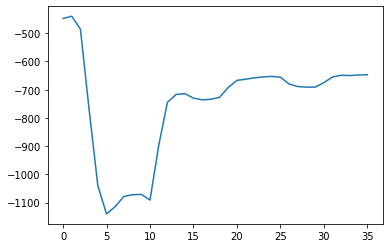

In [20]:
plt.plot(offset50_vals)

Hmm.. so basically most of the vegetation died off in the first few months, but then it staged a recovery after the first rainy month, then moved towards some sort of equilibrium.

This doesn't look a lot like we see in the time series analysis of satellite imagery, but we should bear in mind that this is quite a simplistic model, and that we haven't optimized the configuration for this grid size (in the paper, Konings et al use a 200x200 grid).

With some work in tuning the parameters, it's possible that this could be a useful testbed for some of our analysis tools - e.g. we could introduce both seasonal and long-term trends into the precipitation time series, and see if our decomposition methods can pick these up in the offset50 time series.